PSP Perihelion 1 remote sensing overview
===
Overview of the two coronal holes sampled by PSP during perihelion 1. This notebook:
- Downloads two AIA 193 maps of the coronal holes
- Registers and converts the maps to physical units
- Produces plots of the coronal holes
- Calculates the coronal hole field strengths

In [1]:
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker as mticker
import numpy as np

import sunpy.map
from sunpy.net import Fido, attrs as a

from pubtools import solar as solartools

import solar_library as sollib
from helpers import figwidth, figdir

In [75]:
# Set this to choose the map, 0 for the small CH, 1 for the large CH
n = 0
times = [('2018-10-27 08:00:00', '2018-10-27 08:10:00', '2018-10-27 08:00:00'),
         ('2018-10-30 19:00:00', '2018-10-30 19:10:00', '2018-10-30 19:00:00')]

Search for AIA map
---

In [3]:
result = Fido.search(a.Time(*times[n]),
                     a.Wavelength(193 * u.Angstrom),
                     a.Instrument('AIA'))
result

KeyboardInterrupt: 

Download AIA map
---

In [ ]:
downloaded_files = Fido.fetch(result[0][0])
print(downloaded_files)

Search for HMI map
---

In [4]:
result = Fido.search(t,
                     a.Instrument('HMI'),
                     a.Physobs('LOS_MAGNETIC_FIELD'))
result

Start Time [1],End Time [1],Source,Instrument,Type,Wavelength [2]
,,,,,Angstrom
str19,str19,str3,str3,str8,float64
2018-10-31 19:09:26,2018-10-31 19:09:27,SDO,HMI,FULLDISK,6173.0 .. 6174.0


Download HMI map
---

In [5]:
downloaded_files = Fido.fetch(result)
print(downloaded_files)


['/Users/dstansby/sunpy/data/hmi_m_45s_2018_10_31_19_10_30_tai_magnetogram.fits']


Load the maps
---

In [76]:
# aia_map =  sunpy.map.Map(downloaded_files[0])
if n == 0:
    aia_map = sunpy.map.Map('/Users/dstansby/sunpy/data/aia_lev1_193a_2018_10_27t08_00_04_84z_image_lev1.fits')
    hmi_map = sunpy.map.Map('/Users/dstansby/sunpy/data/hmi_m_45s_2018_10_27_08_01_30_tai_magnetogram.fits')
elif n == 1:
    aia_map = sunpy.map.Map('/Users/dstansby/sunpy/data/aia_lev1_193a_2018_10_31t19_00_04_83z_image_lev1.fits')
    hmi_map = sunpy.map.Map('/Users/dstansby/sunpy/data/hmi_m_45s_2018_10_31_19_10_30_tai_magnetogram.fits')
# Remove invalid values
hmi_map.meta.pop('CRDER1')
hmi_map.meta.pop('CRDER2');

Prep AIA map, and resample to 1024x1024

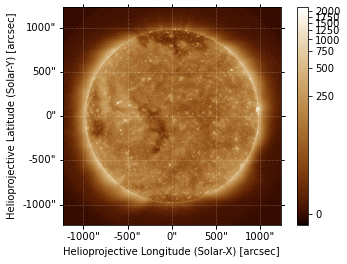

In [77]:
aia_map = solartools.aia_prep(aia_map)
aia_map = aia_map.resample([1024, 1024] * u.pix)
aia_map.peek()

Caclulate intesnity contours on AIA
---

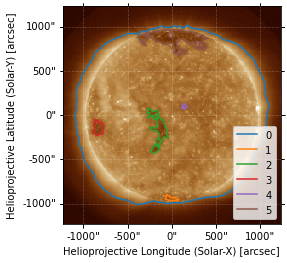

In [78]:
aia_map_small = aia_map.resample([256, 256] * u.pix)
cntrs = solartools.contour(aia_map_small, 50)
# Get rid of small contours
cntrs = [c for c in cntrs if c.shape[0] > 30]

fig = plt.figure()
ax = fig.add_subplot(projection=aia_map_small)
aia_map_small.plot()
for i, c in enumerate(cntrs):
    ax.plot_coord(c, label=str(i))
ax.legend()

In [81]:
ncontour = 2

/Users/dstansby/miniconda3/envs/pub-env/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


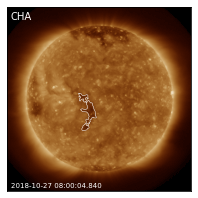

In [82]:
fig = plt.figure(figsize=(figwidth, figwidth))
ax = fig.add_subplot(projection=aia_map)
i = aia_map.plot(interpolation=None, vmin=0, vmax=3000)
ax.plot_coord(cntrs[ncontour], color='w', lw=0.5)
ax.grid()

lon, lat = ax.coords

lon.set_ticks_visible(False)
lon.set_ticklabel_visible(False)
lat.set_ticks_visible(False)
lat.set_ticklabel_visible(False)
lon.set_axislabel('')
lat.set_axislabel('')
chlett = {0: 'A', 1: 'B'}[n]
ax.text(0.02, 0.93, f'CH{chlett}', color='white', transform=ax.transAxes)
ax.text(0.02, 0.02, f'{aia_map.date.iso}', color='white', transform=ax.transAxes, size=7)
ax.set_title('')
fig.savefig(f'{figdir}/CH{n}.pdf', bbox_inches='tight', dpi=200)

Do a cos(L) correction to the HMI data
---
This assumes that the dominant magnetic field component is pointing radially away from the Sun.

In [16]:
# hmi_map = hmi_map.resample([1024, 1024] * u.pix)
hmi_map_corrected = solartools.cos_theta_correction(hmi_map)
areas = solartools.deprojected_areas(hmi_map)

Plot contour on HMI
---

/Users/dstansby/miniconda3/envs/pub-env/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


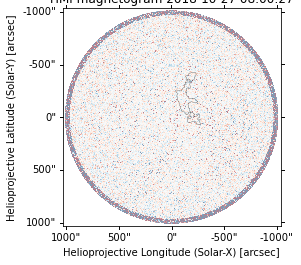

In [81]:
fig = plt.figure()
ax = fig.add_subplot(projection=hmi_map)
hmi_map.plot(vmin=-50, vmax=50, cmap='RdBu', alpha=0.5)
ax.plot_coord(cntrs[ncontour], color='black', lw=0.25)
# fig.savefig(f'figs/CH{n}_hmi.pdf', bbox_inches='tight', dpi=200)

Create a mask for the coronal hole
----

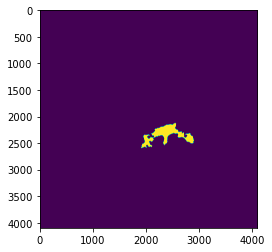

In [84]:
importlib.reload(solartools)

r_mask = solartools.contour_to_mask(cntrs[ncontour], hmi_map, upsample=1)
plt.imshow(r_mask)

(1e-06, 0.1)

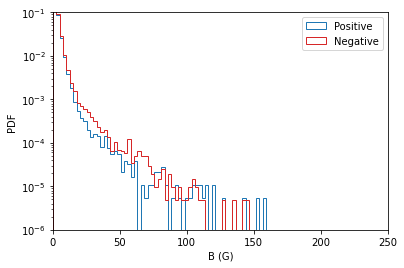

In [85]:
bins = np.linspace(0, 250, 100)
fig, ax = plt.subplots()
# ax.hist(hmi_map.data[r_mask], bins=bins, histtype='step', density=True);
# ax.hist(-hmi_map.data[r_mask], bins=bins, histtype='step', density=True);

ax.hist(hmi_map_corrected.data[r_mask.data], bins=bins,
        histtype='step', density=True,
        label='Positive', color='tab:blue');
ax.hist(-hmi_map_corrected.data[r_mask.data], bins=bins,
        histtype='step', density=True,
        label='Negative', color='tab:red');

# ax.hist(hmi_map.data.ravel(), bins=np.linspace(-200, 200, 100), histtype='step', density=True);

ax.set_yscale('log')
ax.set_xlim(0, 250)
ax.set_xlabel('B (G)')
ax.set_ylabel('PDF')
ax.legend()
ax.set_ylim(1e-6, 1e-1)
# fig.savefig(f'figs/bhist{n}.pdf', bbox_inches='tight')

In [86]:
flux = np.nansum(hmi_map_corrected.data[r_mask.data] * u.gauss * areas[r_mask.data]) 
B = flux / np.nansum(areas[r_mask.data])
B.to(u.G)

<Quantity -0.23537949 G>

Create an AIA colorbar
----

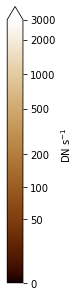

In [61]:
fig, ax = plt.subplots(figsize=(figwidth / 12, figwidth * 1.5))
norm = aia_map.plot_settings['norm']
norm.vmin=0
norm.vmax = 3000
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=aia_map.cmap), cax=ax, extend='max')
cbar.set_ticks([0, 50, 100, 200, 500, 1000, 2000, 3000])
ax.set_ylabel(r'DN s$^{-1}$')
fig.savefig(f'{figdir}/aia_cbar.pdf', bbox_inches='tight')